In [1]:
import sys
sys.path.append('../')
import os
#from utils.imageprocessing import 
#from models.centroid_UNet.predict import predict_img, plot_img_and_mask, mask_to_image
#import torch
#from models.centroid_UNet import model as UNet
from PIL import Image

In [8]:
path = './checkpoints_unet-biomed-b6_2024-05-15_15-30/checkpoint_epoch15.pth'
filename = '../data/2024-04-21-dataset/standard/test/images/tile_tif_23_12.png'

In [9]:
net = UNet(n_channels=3, n_classes=2)#, bilinear=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device=device)

state_dict = torch.load(path, map_location=device)

mask_values = state_dict.pop('mask_values', [0, 255])
net.load_state_dict(state_dict)

<All keys matched successfully>

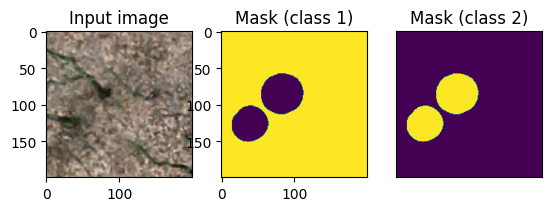

In [10]:
img = Image.open(filename)
mask = predict_img(net=net,
                   full_img=img,
                   scale_factor=1,
                   out_threshold=0.9,
                   device=device)
plot_img_and_mask(img, mask)

In [69]:
mask.max()

1

In [70]:
out_img = mask_to_image(mask,[0, 1])

In [45]:
out_img.save("./test_image.png")

In [12]:
folder = '../data/2024-04-21-dataset/augmentated/orig-test/images'
preds_folder = '../data/2024-04-21-dataset/augmentated/orig-test/biomed-orig-preds'
os.makedirs(preds_folder, exist_ok=True)


for image_path in os.listdir(folder):
    img = Image.open(os.path.join(folder,image_path))
    mask = predict_img(net=net,
                       full_img=img,
                       scale_factor=1,
                       out_threshold=0.9,
                       device=device)
    out_img = mask_to_image(mask,[0, 1])
    x,y = os.path.basename(image_path).split('.')[0].split('_')[2:4]
    out_img.save(os.path.join(preds_folder,f'mask_{x}_{y}.png'))
    

In [14]:
import shutil

In [6]:
shutil.make_archive('predictions-centroid-adam', 'zip', '../data/2024-04-21-dataset/standard/test/predictions-centroid-adam')

'/home/ubuntu/banoczymartin_thesis/TreeDetection/src/predictions-centroid-adam.zip'

In [15]:
shutil.make_archive('orig-predictions-biomed', 'zip', '../data/2024-04-21-dataset/augmentated/orig-test/biomed-orig-preds')


'/home/ubuntu/banoczymartin_thesis/TreeDetection/src/orig-predictions-biomed.zip'

In [53]:

shutil.make_archive('orig-predictions-centroid', 'zip', '../data/2024-04-21-dataset/augmentated/orig-test/centroid-orig-preds')
shutil.make_archive('orig-predictions-biomed', 'zip', '../data/2024-04-21-dataset/augmentated/orig-test/biomed-orig-preds')

'/home/ubuntu/banoczymartin_thesis/TreeDetection/src/orig-predictions-biomed.zip'

In [2]:
shutil.make_archive('images', 'zip', '../data/2024-04-21-dataset/standard/test/images')

'/home/ubuntu/banoczymartin_thesis/TreeDetection/src/images.zip'

In [78]:
shutil.make_archive('masks', 'zip', '../data/2024-04-21-dataset/standard/test/masks')

'/home/ubuntu/banoczymartin_thesis/TreeDetection/src/masks.zip'

In [79]:
shutil.make_archive('orig_set', 'zip', '../data/2024-04-21-dataset/standard/original')


'/home/ubuntu/banoczymartin_thesis/TreeDetection/src/orig_set.zip'

In [3]:
from models.biomed_UNet import evaluate
from models.biomed_UNet import datasets
from torch.utils.data import DataLoader
from models.biomed_UNet import model as UNet


In [74]:
from utils.imageprocessing import convert_PNGtoSHP


In [4]:
os.makedirs('../data/predictions-centroid-shps',exist_ok=True)
os.makedirs('../data/predictions-biomed-shps',exist_ok=True)

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import cv2
from PIL import Image, ImageDraw
from osgeo import gdal, ogr, osr
import rasterio
from rasterio.warp import transform_bounds
from pyproj import Transformer
from shapely.geometry import Point, box
import geopandas as gpd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
import time

import logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    filename='../logs/image_processing.log',
                    filemode='a')


In [10]:
def convert_PNGtoSHP(folder,out_folder, result_folder):
    """
    converts .png files to .shp files from a folder into another folder 
    w/ getPoints_fromPNG(), rasterio, geopandas
    """
    logging.info('conversion from png to shp started')
    filenames = os.listdir(out_folder)
    total_count = len(filenames)
    count=0
    
    out_points = [] 
    with tqdm(total=total_count, desc='converting pngs to shps') as pbar:
        for filename in filenames:
            #if filename.split('_')[1]=='shp':
            image_coords = getPoints_fromPNG(os.path.join(out_folder,filename))
        
            tif_path = os.path.join(folder,filename.replace('mask','tile_tif').replace('_shp_','_tif_').replace('.png','.tif'))
            with rasterio.open(tif_path) as src:
                transform = src.transform  #affine transformation object
                crs = src.crs  #coordinate Reference System
            
            geo_coords = [transform * (x, y) for x, y in image_coords]
        
            #geo_coords -> Points (obj.)
            point_geoms = [Point(coord) for coord in geo_coords]

            #create a GeoDataFrame with the Points
            #gdf = gpd.GeoDataFrame(geometry=point_geoms, crs=crs)  # Adjust CRS as needed

            #save the GeoDataFrame as a shapefile
            #gdf.to_file(os.path.join(result_folder,'pred_'+filename.replace('.png','.shp')))
            #print(os.path.join(result_folder,'pred_'+filename.replace('.png','.shp')))
            count=count+1
            out_points.append(point_geoms)
            pbar.update(1)
    logging.info(f'conversion finished\n\tfrom: {out_folder}\n\tto: {result_folder}\n\tamount: {count}')
    return out_points
    
def getPoints_fromPNG(image_path):
    """
    Returns: the located points from the .png image 
    w/ opencv
    """
    img = cv2.imread(image_path)
    
    #grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #threshold
    _, img_binary = cv2.threshold(img_gray, 200, 255, cv2.THRESH_BINARY)
    
    #find contours
    contours, _ = cv2.findContours(img_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    white_dot_centers = []
    for contour in contours:
        #calculate the moments
        M = cv2.moments(contour)
        
        #calculate centroid coordinates
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            white_dot_centers.append((cX, cY))
    
    return white_dot_centers
    

In [9]:
convert_PNGtoSHP('../data/orig_set 2/tifs','../data/predictions-biomed/','../data/predictions-biomed-shps')
convert_PNGtoSHP('../data/orig_set 2/tifs','../data/predictions-centroid/','../data/predictions-centroid-shps')

converting pngs to shps:   0%|          | 0/29 [00:00<?, ?it/s]

../data/orig_set 2/tifs/tile_tif_30_12.tif
../data/predictions-biomed-shps/pred_mask_30_12.shp
../data/orig_set 2/tifs/tile_tif_32_13.tif
../data/predictions-biomed-shps/pred_mask_32_13.shp
../data/orig_set 2/tifs/tile_tif_30_17.tif
../data/predictions-biomed-shps/pred_mask_30_17.shp
../data/orig_set 2/tifs/tile_tif_30_15.tif
../data/predictions-biomed-shps/pred_mask_30_15.shp
../data/orig_set 2/tifs/tile_tif_26_17.tif
../data/predictions-biomed-shps/pred_mask_26_17.shp
../data/orig_set 2/tifs/tile_tif_28_13.tif
../data/predictions-biomed-shps/pred_mask_28_13.shp
../data/orig_set 2/tifs/tile_tif_27_9.tif
../data/predictions-biomed-shps/pred_mask_27_9.shp
../data/orig_set 2/tifs/tile_tif_28_15.tif
../data/predictions-biomed-shps/pred_mask_28_15.shp
../data/orig_set 2/tifs/tile_tif_26_12.tif
../data/predictions-biomed-shps/pred_mask_26_12.shp
../data/orig_set 2/tifs/tile_tif_34_12.tif
../data/predictions-biomed-shps/pred_mask_34_12.shp
../data/orig_set 2/tifs/tile_tif_23_12.tif
../data/p

converting pngs to shps:   0%|          | 0/29 [00:00<?, ?it/s]

../data/orig_set 2/tifs/tile_tif_30_12.tif
../data/predictions-centroid-shps/pred_mask_30_12.shp
../data/orig_set 2/tifs/tile_tif_32_13.tif
../data/predictions-centroid-shps/pred_mask_32_13.shp
../data/orig_set 2/tifs/tile_tif_30_17.tif
../data/predictions-centroid-shps/pred_mask_30_17.shp
../data/orig_set 2/tifs/tile_tif_30_15.tif
../data/predictions-centroid-shps/pred_mask_30_15.shp
../data/orig_set 2/tifs/tile_tif_26_17.tif
../data/predictions-centroid-shps/pred_mask_26_17.shp
../data/orig_set 2/tifs/tile_tif_28_13.tif
../data/predictions-centroid-shps/pred_mask_28_13.shp
../data/orig_set 2/tifs/tile_tif_27_9.tif
../data/predictions-centroid-shps/pred_mask_27_9.shp
../data/orig_set 2/tifs/tile_tif_28_15.tif
../data/predictions-centroid-shps/pred_mask_28_15.shp
../data/orig_set 2/tifs/tile_tif_26_12.tif
../data/predictions-centroid-shps/pred_mask_26_12.shp
../data/orig_set 2/tifs/tile_tif_34_12.tif
../data/predictions-centroid-shps/pred_mask_34_12.shp
../data/orig_set 2/tifs/tile_tif

In [17]:
points = convert_PNGtoSHP('../data/orig_set 2/tifs','../data/predictions-biomed/','../data/predictions-biomed-shps')

converting pngs to shps:   0%|          | 0/29 [00:00<?, ?it/s]

../data/orig_set 2/tifs/tile_tif_30_12.tif
../data/orig_set 2/tifs/tile_tif_32_13.tif
../data/orig_set 2/tifs/tile_tif_30_17.tif
../data/orig_set 2/tifs/tile_tif_30_15.tif
../data/orig_set 2/tifs/tile_tif_26_17.tif
../data/orig_set 2/tifs/tile_tif_28_13.tif
../data/orig_set 2/tifs/tile_tif_27_9.tif
../data/orig_set 2/tifs/tile_tif_28_15.tif
../data/orig_set 2/tifs/tile_tif_26_12.tif
../data/orig_set 2/tifs/tile_tif_34_12.tif
../data/orig_set 2/tifs/tile_tif_23_12.tif
../data/orig_set 2/tifs/tile_tif_23_13.tif
../data/orig_set 2/tifs/tile_tif_31_13.tif
../data/orig_set 2/tifs/tile_tif_23_11.tif
../data/orig_set 2/tifs/tile_tif_33_14.tif
../data/orig_set 2/tifs/tile_tif_31_10.tif
../data/orig_set 2/tifs/tile_tif_29_9.tif
../data/orig_set 2/tifs/tile_tif_31_16.tif
../data/orig_set 2/tifs/tile_tif_29_11.tif
../data/orig_set 2/tifs/tile_tif_25_11.tif
../data/orig_set 2/tifs/tile_tif_29_13.tif
../data/orig_set 2/tifs/tile_tif_25_12.tif
../data/orig_set 2/tifs/tile_tif_29_17.tif
../data/orig_

In [18]:
def flatten_list(nested_list):
    flattened_list = []
    for sublist in nested_list:
        if isinstance(sublist, list):
            flattened_list.extend(flatten_list(sublist))
        else:
            flattened_list.append(sublist)
    return flattened_list

flattened = flatten_list(points)
print(flattened)

[<POINT (549108.529 221317.887)>, <POINT (549108.009 221319.827)>, <POINT (549113.069 221311.947)>, <POINT (549126.609 221320.507)>, <POINT (549128.649 221335.487)>, <POINT (549112.349 221327.407)>, <POINT (549112.129 221327.687)>, <POINT (549112.749 221327.887)>, <POINT (549110.229 221327.887)>, <POINT (549111.669 221329.087)>, <POINT (549095.049 221330.107)>, <POINT (549119.449 221328.487)>, <POINT (549108.209 221335.907)>, <POINT (549106.649 221337.107)>, <POINT (549107.349 221303.387)>, <POINT (549106.189 221346.847)>, <POINT (549107.069 221347.667)>, <POINT (549112.949 221315.647)>, <POINT (549103.209 221347.807)>, <POINT (549116.149 221309.087)>, <POINT (549100.709 221316.107)>, <POINT (549098.309 221317.267)>, <POINT (549096.249 221321.767)>, <POINT (549094.909 221324.147)>, <POINT (549123.369 221316.887)>, <POINT (549102.809 221323.207)>, <POINT (549113.209 221325.107)>, <POINT (549107.249 221339.607)>, <POINT (549108.989 221339.987)>, <POINT (549127.349 221322.947)>, <POINT (5

In [19]:
gdf = gpd.GeoDataFrame(geometry=flattened, crs=23700)  # Adjust CRS as needed
gdf.to_file('../data/conc_biomed.shp')

In [ ]:
from utils.imageprocessing import create_shapefile